In [1]:
import matplotlib.pyplot as plt
from hydromt_sfincs import SfincsModel, utils
import xarray as xr
import os
import numpy as np
from os.path import join
import matplotlib.pyplot as plt
import hydromt 
from hydromt_sfincs import SfincsModel
from matplotlib import animation
from hydromt.config import configread
from hydromt.log import setuplog


## Get SFINCS model

In [2]:
#sfincs_root_base = r"c:\git\sfincs_alblasserwaard\sfincs_discharge_base"  # (relative) path to sfincs root

sfincs_root = r"p:\11209905-dca-sfincs-river\01_models\KoldingA_PAK_sbg20_waterlevel_bound"
#scenario_name = f"WL_{waterlevel}_breach_{breach}_depth_adjust_{depth_adjust}"

working_dir = os.path.abspath(".")


logger = setuplog("update", "./hydromt.log", log_level=10)
yml_file = join(working_dir, "setup_sfincs_kolding.yml")
opt = configread(yml_file)  # read settings from ini file
kwargs = opt.pop("global", {})

mod = SfincsModel(sfincs_root, mode="r", logger= logger, **kwargs)

 # Select our highest-resolution elevation dataset
dep = mod.data_catalog.get_rasterdataset("DEM_5x5m")



2024-03-06 08:41:14,647 - update - log - DEBUG - Appending log messages to file ./hydromt.log.
2024-03-06 08:41:14,649 - update - log - INFO - HydroMT version: 0.9.3
2024-03-06 08:41:14,814 - update - data_catalog - INFO - Parsing data catalog from c:/git/DCA_sfincs/02_scripts/input/local_data.yml
2024-03-06 08:41:15,337 - update - data_catalog - INFO - Reading data catalog deltares_data v2024.1.30
2024-03-06 08:41:15,338 - update - data_catalog - INFO - Parsing data catalog from https://raw.githubusercontent.com/Deltares/hydromt/main/data/catalogs/deltares_data.yml
2024-03-06 08:41:16,280 - update - log - DEBUG - Appending log messages to file p:\11209905-dca-sfincs-river\01_models\KoldingA_PAK_sbg20_waterlevel_bound\hydromt.log.
2024-03-06 08:41:16,282 - update - model_api - INFO - Initializing sfincs model from hydromt_sfincs (v1.0.3).
2024-03-06 08:41:16,301 - update - rasterdataset - INFO - Reading DEM_5x5m raster data from p:\11209905-dca-sfincs-river\00_data\DEM\kolding_DHM_5x5_

## Plotting maximum waterlevel

In [3]:
zsmax = mod.results["zsmax"]
zsmax = zsmax.max(dim='timemax')

bed_level =  mod.results["zb"].copy()
water_level_max = zsmax - bed_level

hmin = 0.01

print("Hello")

hmax = utils.downscale_floodmap(
    zsmax=water_level_max,
    dep=dep, #Use subgrid
    hmin=hmin,
    # gdf_mask=gdf_osm,
    floodmap_fn=join(sfincs_root, "floodmap.tif") # uncomment to save to <mod.root>/floodmap.tif
)

print("Hello2")

fig, ax = mod.plot_basemap(
    fn_out=None,
    variable="", # no variable to plot, only basemap
    plot_bounds=False, 
    bmap="sat",
    zoomlevel=12,
    figsize=(11, 7),
)

print("Hello3")

cbar_kwargs = {"shrink": 0.6, "anchor": (0, 0)}
cax_fld = water_level_max.plot(
    x="x", y="y",
    ax=ax,
    vmin=0.0, vmax=3.0,
    cmap=plt.cm.viridis,
    cbar_kwargs=cbar_kwargs,
)

print("Hello4")


ax.set_title(f"SFINCS maximum water depth")
#plt.savefig(join(scenario_dir, 'hmax.png'), dpi=225, bbox_inches="tight")
plt.show()


Hello


## Forcing


(<Figure size 600x600 with 2 Axes>,
 array([<Axes: title={'center': 'SFINCS waterlevel forcing (bzs)'}, ylabel='waterlevel\n[m+ref]'>,
        <Axes: title={'center': 'SFINCS discharge forcing (dis)'}, ylabel='discharge\n[m3.s-1]'>],
       dtype=object))

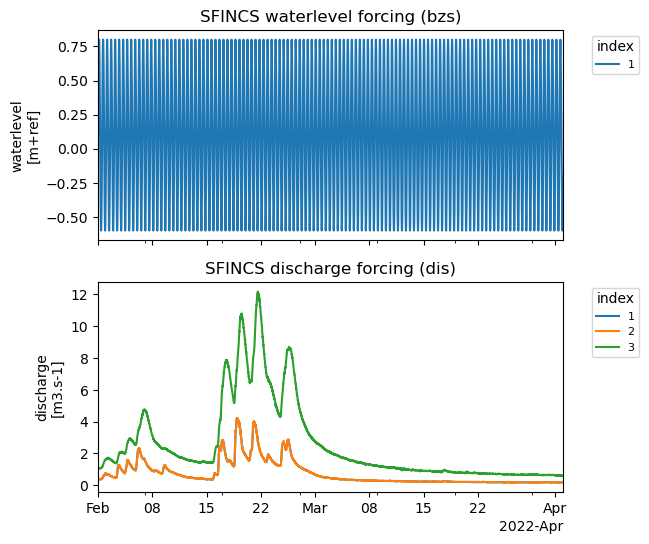

In [14]:
mod.plot_forcing()

## Amimation

In [17]:
print("Make animation")

hmin = 0.05
da_h = mod.results["zs"].copy() - mod.results["zb"].copy()
da_h = da_h.where(da_h > hmin).drop("spatial_ref")
da_h.attrs.update(long_name="flood depth", unit="m")

step = 10  # one frame every <step> dtout
cbar_kwargs = {"shrink": 0.6, "anchor": (0, 0)}


def update_plot(i, da_h, cax_h):
    da_hi = da_h.isel(time=i)
    t = da_hi.time.dt.strftime("%d-%B-%Y %H:%M:%S").item()
    print( f"Animation t= {t}")
    ax.set_title(f"SFINCS water depth {t}")
    cax_h.set_array(da_hi.values.ravel())


fig, ax = mod.plot_basemap(
    fn_out=None, variable="", bmap="sat", plot_bounds=False, figsize=(11, 7)
)
cax_h = da_h.isel(time=0).plot(
    x="x", y="y",
    ax=ax,
    vmin=0, vmax=3,
    cmap=plt.cm.viridis,
    cbar_kwargs=cbar_kwargs
)
plt.close()  # to prevent double plot

ani = animation.FuncAnimation(
    fig,
    update_plot,
    frames=np.arange(0, da_h.time.size, step),
    interval=250,  # ms between frames
    fargs=(
        da_h,
        cax_h,
    ),
)

# to save to mp4
ani.save(join(sfincs_root , 'sfincs_h.mp4'), fps=4, dpi=200)


Make animation
Animation t= 01-February-2022 00:00:00
Animation t= 01-February-2022 00:00:00
Animation t= 01-February-2022 10:00:00
Animation t= 01-February-2022 20:00:00
Animation t= 02-February-2022 06:00:00
Animation t= 02-February-2022 16:00:00
Animation t= 03-February-2022 02:00:00
Animation t= 03-February-2022 12:00:00
Animation t= 03-February-2022 22:00:00
Animation t= 04-February-2022 08:00:00
Animation t= 04-February-2022 18:00:00
Animation t= 05-February-2022 04:00:00
Animation t= 05-February-2022 14:00:00
Animation t= 06-February-2022 00:00:00
Animation t= 06-February-2022 10:00:00
Animation t= 06-February-2022 20:00:00
Animation t= 07-February-2022 06:00:00
Animation t= 07-February-2022 16:00:00
Animation t= 08-February-2022 02:00:00
Animation t= 08-February-2022 12:00:00
Animation t= 08-February-2022 22:00:00
Animation t= 09-February-2022 08:00:00
Animation t= 09-February-2022 18:00:00
Animation t= 10-February-2022 04:00:00
Animation t= 10-February-2022 14:00:00
Animation 